# Ensemble-based models to predict age

**Can we predict age from blood gene expression data?**

- Random forest
- XGBoost

author: @emilyekstrum
<br> 12/11/25

In [18]:
#load in modules
import numpy as np
import pandas as pd
import gzip
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# load latent spaces
latent_spaces = np.load('gtex_latent_spaces.npz')
pca_result_2d = latent_spaces['pca_2d']
pca_result_85 = latent_spaces['pca_hd']
umap_result_2d = latent_spaces['umap_from_2d']
umap_result_hd = latent_spaces['umap_from_hd']

print(f"Latent space shapes:")
print(f"PCA 2D: {pca_result_2d.shape}")
print(f"PCA high-D: {pca_result_85.shape}")
print(f"UMAP from 2D: {umap_result_2d.shape}")
print(f"UMAP from high-D: {umap_result_hd.shape}")

Latent space shapes:
PCA 2D: (12289, 2)
PCA high-D: (12289, 83)
UMAP from 2D: (12289, 2)
UMAP from high-D: (12289, 2)


In [20]:
# open merged dataframe to get age and tissue labels
with gzip.open('GTEx_merged_processed_data.csv.gz', 'rt') as f:
    merged_df = pd.read_csv(f)

# extract age and tissue labels
age_labels = merged_df['AGE'].values
tissue_labels = merged_df['SMTS'].values
print(f"Number of samples: {len(age_labels)}")
print(f"Age range: {np.nanmin(age_labels)} - {np.nanmax(age_labels)}")

Number of samples: 12289
Age range: 25 - 75


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_74010/1878618888.py:3: DtypeWarning: Columns (5008) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(f)


In [21]:
# select only blood samples from latent spaces and labels
blood_mask = merged_df['SMTS'] == 'Blood'
blood_indices = merged_df[blood_mask].index

# subset latent spaces and age labels for blood samples
pca_2d_blood = pca_result_2d[blood_indices]
pca_hd_blood = pca_result_85[blood_indices]
umap_2d_blood = umap_result_2d[blood_indices]
umap_hd_blood = umap_result_hd[blood_indices]
age_blood = age_labels[blood_indices]

# remove NaN ages
valid_age_mask = ~np.isnan(age_blood)
pca_2d_blood = pca_2d_blood[valid_age_mask]
pca_hd_blood = pca_hd_blood[valid_age_mask]
umap_2d_blood = umap_2d_blood[valid_age_mask]
umap_hd_blood = umap_hd_blood[valid_age_mask]
age_blood = age_blood[valid_age_mask]

### Fit ensemble models to predict age

In [22]:
# Random forest to predict age from each latent space - blood samples only

# latent spaces dictionary for blood samples
blood_latent_spaces = {
    'PCA_2D': pca_2d_blood,
    'PCA_HighD': pca_hd_blood,
    'UMAP_from_2D': umap_2d_blood,
    'UMAP_from_HighD': umap_hd_blood
}

# store results
rf_results = {}

for space_name, X_data in blood_latent_spaces.items():
    print(f"\nTraining Random Forest on {space_name}")
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, age_blood, test_size=0.2, random_state=42
    )
    
    # fit random forest regressor
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # predictions
    y_pred = rf_model.predict(X_test)
    
    # calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R^2: {r2:.4f}")
    
    # store results
    rf_results[space_name] = {
        'model': rf_model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred
    }

print("\nRandom Forest Results Summary:")
for space_name, results in rf_results.items():
    print(f"{space_name:15} - RMSE: {results['rmse']:.2f}, R^2: {results['r2']:.4f}")


Training Random Forest on PCA_2D
RMSE: 13.45
MAE: 11.07
R^2: -0.0824

Training Random Forest on PCA_HighD
RMSE: 12.51
MAE: 10.13
R^2: 0.0639

Training Random Forest on UMAP_from_2D
RMSE: 13.46
MAE: 11.11
R^2: -0.0837

Training Random Forest on UMAP_from_HighD
RMSE: 12.93
MAE: 10.29
R^2: 0.0008

Random Forest Results Summary:
PCA_2D          - RMSE: 13.45, R^2: -0.0824
PCA_HighD       - RMSE: 12.51, R^2: 0.0639
UMAP_from_2D    - RMSE: 13.46, R^2: -0.0837
UMAP_from_HighD - RMSE: 12.93, R^2: 0.0008


In [23]:
# XGBoost regressor to predict age from each latent space - blood samples only

# store xgb results
xgb_results = {}

for space_name, X_data in blood_latent_spaces.items():
    print(f"\nTraining XGBoost on {space_name}")
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, age_blood, test_size=0.2, random_state=42
    )
    
    # fit XGBoost regressor
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    xgb_model.fit(X_train, y_train)
    
    # predictions
    y_pred = xgb_model.predict(X_test)
    
    # calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    # store results
    xgb_results[space_name] = {
        'model': xgb_model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred
    }

print("\nXGBoost Results Summary:")
for space_name, results in xgb_results.items():
    print(f"{space_name:15} - RMSE: {results['rmse']:.2f}, R^2: {results['r2']:.4f}")


Training XGBoost on PCA_2D
RMSE: 13.69
MAE: 11.09
R²: -0.1213

Training XGBoost on PCA_HighD
RMSE: 13.15
MAE: 10.74
R²: -0.0341

Training XGBoost on UMAP_from_2D
RMSE: 13.69
MAE: 11.18
R²: -0.1205

Training XGBoost on UMAP_from_HighD
RMSE: 13.93
MAE: 10.85
R²: -0.1604

XGBoost Results Summary:
PCA_2D          - RMSE: 13.69, R^2: -0.1213
PCA_HighD       - RMSE: 13.15, R^2: -0.0341
UMAP_from_2D    - RMSE: 13.69, R^2: -0.1205
UMAP_from_HighD - RMSE: 13.93, R^2: -0.1604


### Model evaluation

In [24]:
# compare model performances

spaces = list(rf_results.keys())
print("\nPerformance by latent space:")
for space in spaces:
    rf_r2 = rf_results[space]['r2']
    rf_rmse = rf_results[space]['rmse']
    xgb_r2 = xgb_results[space]['r2']
    xgb_rmse = xgb_results[space]['rmse']
    print(f"{space:15} - RF: R^2={rf_r2:.4f}, RMSE={rf_rmse:.2f} | XGB: R^2={xgb_r2:.4f}, RMSE={xgb_rmse:.2f}")

# find best models
best_rf = max(rf_results.items(), key=lambda x: x[1]['r2'])
best_xgb = max(xgb_results.items(), key=lambda x: x[1]['r2'])

print(f"\nBest Random Forest: {best_rf[0]} (R^2: {best_rf[1]['r2']:.4f})")
print(f"Best XGBoost: {best_xgb[0]} (R^2: {best_xgb[1]['r2']:.4f})")

# overall best
if best_rf[1]['r2'] > best_xgb[1]['r2']:
    overall_best = ('Random Forest', best_rf[0], best_rf[1]['r2'])
    best_results = rf_results[best_rf[0]]
else:
    overall_best = ('XGBoost', best_xgb[0], best_xgb[1]['r2'])
    best_results = xgb_results[best_xgb[0]]

print(f"\nOverall Best: {overall_best[0]} on {overall_best[1]} (R^2: {overall_best[2]:.4f})")


Performance by latent space:
PCA_2D          - RF: R^2=-0.0824, RMSE=13.45 | XGB: R^2=-0.1213, RMSE=13.69
PCA_HighD       - RF: R^2=0.0639, RMSE=12.51 | XGB: R^2=-0.0341, RMSE=13.15
UMAP_from_2D    - RF: R^2=-0.0837, RMSE=13.46 | XGB: R^2=-0.1205, RMSE=13.69
UMAP_from_HighD - RF: R^2=0.0008, RMSE=12.93 | XGB: R^2=-0.1604, RMSE=13.93

Best Random Forest: PCA_HighD (R^2: 0.0639)
Best XGBoost: PCA_HighD (R^2: -0.0341)

Overall Best: Random Forest on PCA_HighD (R^2: 0.0639)


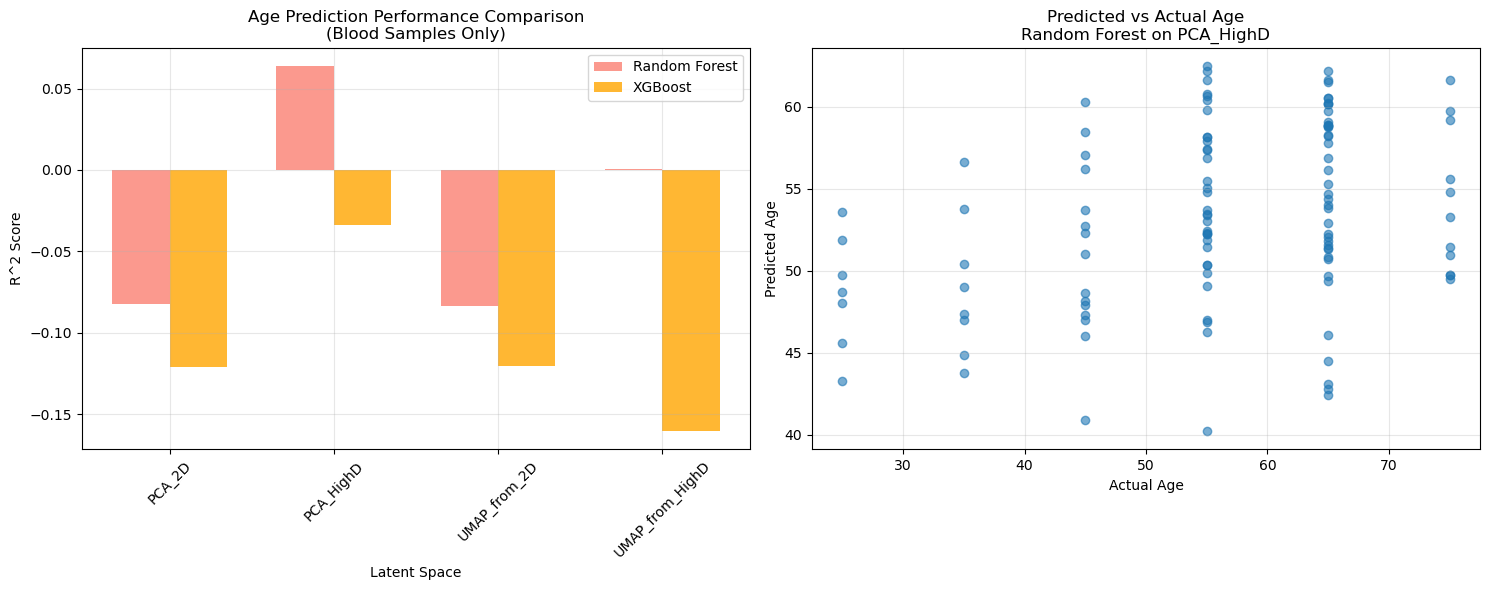


Summary: Best performance achieved with Random Forest on PCA_HighD latent space
R^2 Score: 0.0639 (explains 6.4% of age variance)
High-dimensional PCA retains more age-relevant information in blood samples


In [25]:
# visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# performance comparison
rf_r2s = [rf_results[space]['r2'] for space in spaces]
xgb_r2s = [xgb_results[space]['r2'] for space in spaces]

x = np.arange(len(spaces))
width = 0.35

ax1.bar(x - width/2, rf_r2s, width, label='Random Forest', alpha=0.8, color='salmon')
ax1.bar(x + width/2, xgb_r2s, width, label='XGBoost', alpha=0.8, color='orange')
ax1.set_xlabel('Latent Space')
ax1.set_ylabel('R^2 Score')
ax1.set_title('Age Prediction Performance Comparison\n(Blood Samples Only)')
ax1.set_xticks(x)
ax1.set_xticklabels(spaces, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# predicted vs actual for best model
ax2.scatter(best_results['y_test'], best_results['y_pred'], alpha=0.6)
ax2.set_xlabel('Actual Age')
ax2.set_ylabel('Predicted Age')
ax2.set_title(f'Predicted vs Actual Age\n{overall_best[0]} on {overall_best[1]}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary: Best performance achieved with {overall_best[0]} on {overall_best[1]} latent space")
print(f"R^2 Score: {overall_best[2]:.4f} (explains {overall_best[2]*100:.1f}% of age variance)")
if 'HighD' in overall_best[1]:
    print("High-dimensional PCA retains more age-relevant information in blood samples")
else:
    print("Lower-dimensional representation captures sufficient age-related patterns")

In [26]:
# classification report for best model
print(f"\nClassification Report - {overall_best[0]} on {overall_best[1]}:")

# Convert continuous predictions to discrete class labels
y_pred_rounded = np.round(best_results['y_pred']).astype(int)
y_test_rounded = best_results['y_test'].astype(int)

print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - Random Forest on PCA_HighD:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          35       0.00      0.00      0.00         8
          40       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         0
          54       0.00     

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [27]:
# classificiation report for random forest on PCA 2D
print(f"\nClassification Report - Random Forest on PCA_2D:")
y_pred_rounded = np.round(rf_results['PCA_2D']['y_pred']).astype(int)
y_test_rounded = rf_results['PCA_2D']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - Random Forest on PCA_2D:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          35       0.00      0.00      0.00         8
          40       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.50      0.13      0.21        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         0
          54       0.00      0.00      0.00         0
          55       0.29      0.06      0.10        34
          56       0.00      0.

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [28]:
# classification report for random forest on UMAP from 2D
print(f"\nClassification Report - Random Forest on UMAP_from_2D:")
y_pred_rounded = np.round(rf_results['UMAP_from_2D']['y_pred']).astype(int)
y_test_rounded = rf_results['UMAP_from_2D']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))    


Classification Report - Random Forest on UMAP_from_2D:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          34       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         8
          36       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00  

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [29]:
# classification report for random forest high dimensional
print(f"\nClassification Report - Random Forest on PCA_HighD:")
y_pred_rounded = np.round(rf_results['PCA_HighD']['y_pred']).astype(int)
y_test_rounded = rf_results['PCA_HighD']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - Random Forest on PCA_HighD:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          35       0.00      0.00      0.00         8
          40       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         0
          54       0.00     

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [30]:
# classification report for XGBoost on PCA 2d
print(f"\nClassification Report - XGBoost on PCA_2D:")
y_pred_rounded = np.round(xgb_results['PCA_2D']['y_pred']).astype(int)
y_test_rounded = xgb_results['PCA_2D']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - XGBoost on PCA_2D:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          32       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         8
          36       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         0
          54       0.00      0.00    

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [31]:
# classification report for XGBoost on PCA from high-D
print(f"\nClassification Report - XGBoost on UMAP_from_HighD:")
y_pred_rounded = np.round(xgb_results['UMAP_from_HighD']['y_pred']).astype(int)
y_test_rounded = xgb_results['UMAP_from_HighD']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - XGBoost on UMAP_from_HighD:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          31       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         8
          37       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00     

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [32]:
# classification report for XGBoost on UMAP from 2D
print(f"\nClassification Report - XGBoost on UMAP_from_2D:")
y_pred_rounded = np.round(xgb_results['UMAP_from_2D']['y_pred']).astype(int)
y_test_rounded = xgb_results['UMAP_from_2D']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - XGBoost on UMAP_from_2D:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          35       0.00      0.00      0.00         8
          37       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         0
          54       0.00      0.

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [33]:
# classification report for XGBoost on UMAP from high-D
print(f"\nClassification Report - XGBoost on UMAP_from_HighD:")
y_pred_rounded = np.round(xgb_results['UMAP_from_HighD']['y_pred']).astype(int)
y_test_rounded = xgb_results['UMAP_from_HighD']['y_test'].astype(int)
print(classification_report(y_test_rounded, y_pred_rounded))


Classification Report - XGBoost on UMAP_from_HighD:
              precision    recall  f1-score   support

          25       0.00      0.00      0.00         7
          31       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         8
          37       0.00      0.00      0.00         0
          39       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00        15
          46       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          51       0.00     

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

**Overall, the random forest and XGBoost predictors performed poorly when tasked with predicting the age of samples using latent space represenations of gene expression data. Across the board, there are low accuracy and r^2 values, indicating the models do not predict age well and low variance explanation.**